# Tarea 2: ¿Es posible explicar la cantidad de billonarios en base al desarrollo país?  <a class="tocSkip"></a>







En 2006 *Daniel Treisman* publicó un artículo titulado [*Russia Billionaries*](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068) en el cual conectó la cantidad de billonarios de un país con ciertos atributos económicos de los mismos. 

Su conclusión principal fue que ***Rusia tiene una cantidad de billonarios mayor que la que predicen los indicadores económicos***

En esta tarea ustedes analizarán datos macroeconómicos para comprobar o refutar los hallazgos de *D. Treisman*

## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas de programación si no se cumple este requisito
1. Su tarea se evaluará en base al último commit antes de la fecha de entrega: **14:10 del Martes 15 de Junio de 2021**. La nota se calcula como ("pt totales" + 1)
1. [Sean leales y honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish), no copie ni comparta resultados con otros grupos

## Datos

Para esta tarea se les provee de un conjunto de datos `billonarios.csv` indexado por país con los siguientes atributos

- `nbillonarios`: La cantidad de billonarios del pais
- `logpibpc`: El logaritmo del Producto Interno Bruto (PIB) per capita del pais
- `logpob`: El logaritmo de la población del pais
- `gatt`: La cantidad de años que el pais está adherido al *General Agreement on Tariffs and Trade* (GATT)

In [69]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import poisson
import scipy
import ipywidgets as widgets
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')

df = pd.read_csv("billonarios.csv")
df[0:].head()

,pais,nbillonarios,logpibpc,logpob,gatt
0,United States,469,10.786021,19.532846,60
1,Canada,25,10.743365,17.319439,0
2,"Bahamas, The",0,10.072139,12.760934,0
3,Aruba,0,10.223734,11.526276,0
4,Bermuda,0,11.446847,11.086334,0


## Modelo (1.0pt)

El objetivo principal de esta tarea es entrenar un modelo de regresión que prediga la cantidad de billonarios en función de los demás atributos

> El número de billonarios es una variable entera y no-negativa. 

Un modelo apropiado en este caso es la [regresión de Poisson](https://en.wikipedia.org/wiki/Poisson_distribution), donde definimos la probabilidad condicional para un pais $i$ como  

$$
p(y_i | x_i ) = \frac{\lambda_i^{y_i}}{y_i!} \exp \left ({-\lambda_i} \right)
$$

con intensidad

$$
\lambda_i = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{ij} \right)
$$

donde 

- $\theta$ es el vector de parámetros que deseamos ajustar 
- $y_i$ y $x_i$ son la cantidad de billonarios y el vector de atributos del país $i$, respectivamente

En base a este modelo se pide que ajusten $\theta$ mediante la maximización de la verosimilitud. 

$$
\begin{align}
\hat \theta &= \text{arg}\max_\theta \log \mathcal{L} (\theta) \nonumber \\ 
&= \text{arg}\max_\theta \log \prod_{i=1}^N  p(y_i | x_i) \nonumber \\
&= \text{arg}\max_\theta \sum_{i=1}^N \log p(y_i | x_i) \nonumber
\end{align}
$$

En particular:

**1. Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro $\lambda$, ¿Qué ocurre cuando $\lambda$ es pequeño? ¿Y cuando es grande?**

La distribución de Poisson es una distribución de tipo discreta que permite modelar la probabilidad de que k fenómenos ocurran en un periodo fijo de tiempo (conociendo la tasa media (λ) de ocurrencia de estos). Además se supone que los tiempos entre ocurrencias son independientes entre sí y distribuidos exponencialmente. Esto significa que por ejemplo, si se conoce la tasa media de llegada de micros a un paradero (1 cada 15 minutos) y han transcurrido 5 minutos desde la última llegada, la probabilidad con la que se debe esperar 15 minutos para que llegue una nueva micro sigue siendo la misma que si hubieran transcurrido 0 minutos, o sea, los tiempos entre llegadas son independientes entre sí.

<IPython.core.display.Javascript object>


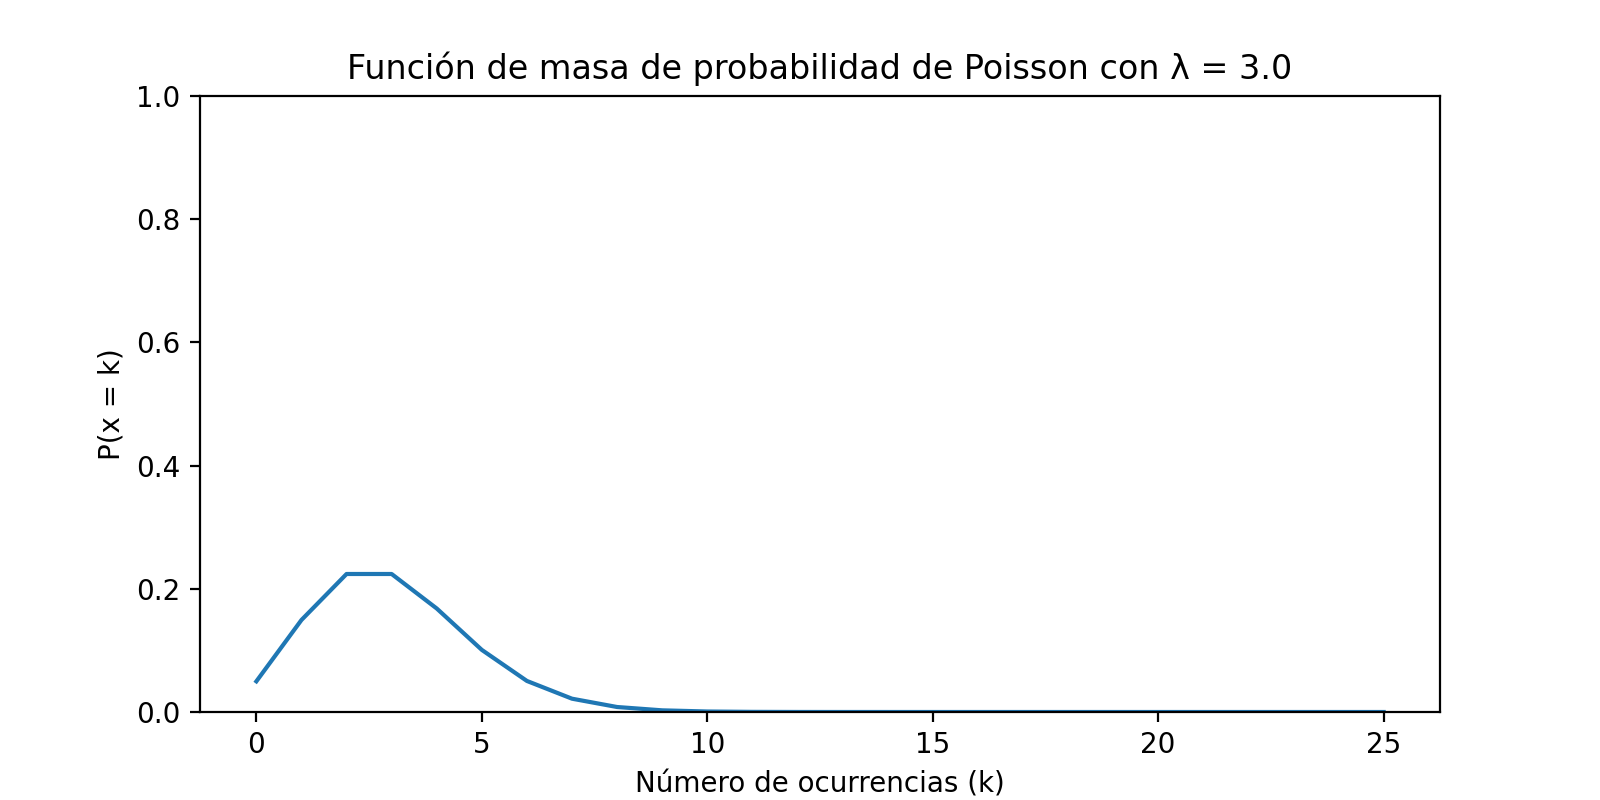

interactive(children=(FloatSlider(value=12.0, description='λ', max=25.0, step=0.5), Output()), _dom_classes=('…

In [52]:
k = np.arange(0,26,1)
fig, ax = plt.subplots(figsize=(8,4))
@widgets.interact(λ=(0, 25, 0.5))
def poissonMass(λ):
    y = poisson.pmf(k,λ)
    ax.cla()
    ax.set_title("Función de masa de probabilidad de Poisson con λ = " + str(λ))
    ax.set_ylim([0, 1])
    ax.set_ylabel("P(x = k)")
    ax.set_xlabel("Número de ocurrencias (k)")
    ax.plot(k,y)

<IPython.core.display.Javascript object>


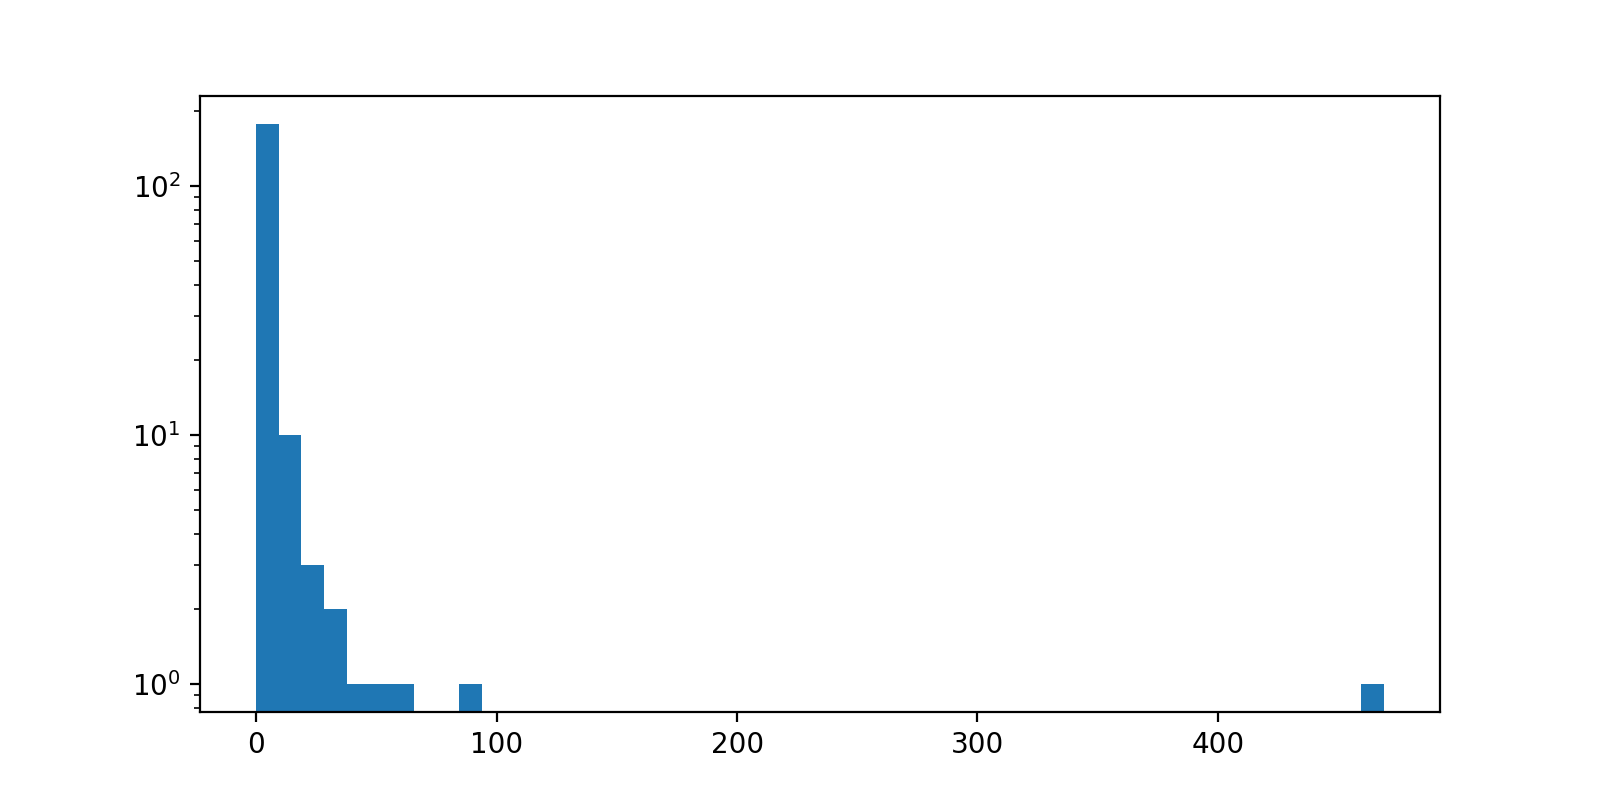

In [3]:
fig, ax = plt.subplots(figsize=(8,4))
h = ax.hist(df.iloc[:,1],50,log=True)

In [4]:
print("Media y:",np.mean(df.iloc[:,1]),"Varianza y:",np.var(df.iloc[:,1]))

Media y: 5.675126903553299 Varianza y: 1198.27009198898


In [5]:
# Varianza mucho mayor que la media, por lo tanto suponemos que habrá sobre dispersión

Podemos ver que la distribución se asemeja a una distribución normal, cuya media o centro parece ser igual al parámetro λ. También podemos observar que a medida que λ aumenta, también lo hace la varianza.
    
**2. Reemplace las expresiones y obtenga una expresión analítica para el logaritmo de la verosimilitud: $\log \mathcal{L}(\theta)$. Muestre la ecuación obtenida. HINT: Puede ignorar los términos que no dependan de $\theta$. Luego obtenga una expresión analítica para la primera derivada del logaritmo de la verosimilitud. Muestra la ecuación obtenida**
$$
\begin{align}
\log \mathcal{L}(\theta) &= \sum_{i=1}^N \log p(y_i | x_i) \nonumber \\
\nonumber \\ 
&= \sum_{i=1}^N \log\left(\frac{\lambda_i^{y_i}}{y_i!} e^{-\lambda_i}\right) \nonumber \\
\text{Usamos propiedad logarítmica:} \nonumber \\ 
\log(a \cdot b) = \log(a) + \log(b) \nonumber \\ 
\nonumber \\ 
&= \sum_{i=1}^N \left( \log\left(\frac{\lambda_i^{y_i}}{y_i!} \right) + \log\left(e^{-\lambda_i}\right) \right) \nonumber \\
&= \sum_{i=1}^N \left( \log\left(\frac{\lambda_i^{y_i}}{y_i!} \right) - \lambda_i \right)  \nonumber \\
\nonumber \\ 
\text{Usamos propiedad logarítmica:} \nonumber \\ 
\log\left(\frac{a}{b}\right) = \log(a) - \log(b) \nonumber \\ 
\nonumber \\ 
&= \sum_{i=1}^N \left( \log\left(\lambda_i^{y_i}\right) - \log(y_i!) - \lambda_i \right)  \nonumber \\
\nonumber \\ 
\text{Reemplazamos } \lambda_i \nonumber \\
\nonumber \\ 
&= \sum_{i=1}^N \left( \log \left(\left(e^{\left(\theta_0 + \sum_{j=1}^M \theta_j x_{ij}\right)}\right)^{y_i}\right) - \log(y_i!) - e^{\left(\theta_0 + \sum_{j=1}^M \theta_j x_{ij}\right)} \right) \nonumber \\
\nonumber \\ 
\text{Usamos propiedad exponencial:} \nonumber \\ 
(e^{a})^{b} = e^{a \cdot b} \nonumber \\ 
\nonumber \\ 
&= \sum_{i=1}^N \left( \log \left(e^{\left(\theta_0 + \sum_{j=1}^M \theta_j x_{ij}\right)y_i}\right) - \log(y_i!) - e^{\left(\theta_0 + \sum_{j=1}^M \theta_j x_{ij}\right)} \right) \nonumber \\
&= \sum_{i=1}^N \left( (\theta_0 + \sum_{j=1}^M \theta_j x_{ij}) y_i - \log(y_i!) - e^{(\theta_0 + \sum_{j=1}^M \theta_j x_{ij})} \right) \nonumber \\
\nonumber \\ 
\text{Por último, podemos eliminar } \log(y_i!) \text{ ya que no depende de }\theta \nonumber \\
\nonumber \\ 
&= \sum_{i=1}^N \left( (\theta_0 + \sum_{j=1}^M \theta_j x_{ij}) y_i - e^{(\theta_0 + \sum_{j=1}^M \theta_j x_{ij})} \right) \nonumber \\
\end{align}
$$

### Derivada
La derivada respecto a  $ \theta_j$ con $\text{j = 0}$ es:

$$
\begin{align}
\frac{d}{d\theta_0}\log \mathcal{L}(\theta) &= \sum_{i=1}^N\left( y_i - e^{(\theta_0 + \sum_{j=1}^M \theta_j x_{ij})} \right) \nonumber \\
\end{align}
$$

Y para $\text{j > 0}$ es:

$$
\begin{align}
\frac{d}{d\theta_j}\log \mathcal{L}(\theta) &= \sum_{i=1}^N\left( x_{ij} y_i - x_{ij}e^{(\theta_0 + \sum_{j=1}^M \theta_j x_{ij})} \right) \nonumber \\
\end{align}
$$

## Implementación (1.5pt)

**1. Implemente el logaritmo de la verosimilitud y su derivada usando `numpy`. Utilice operaciones vectoriales (prohibido usar `for` para iterar en los países)**


In [92]:
# Función de costo
def loglikelihood(theta,*args):
    y = args[0]
    x = args[1]
    
    p = theta[0] + np.sum(theta[1:]*x,axis=1)
    sum1 = p*y
    sum2 = np.exp(p)
    
    # Cambiamos signo para que se convierta en minimización
    return -np.sum(sum1 - sum2)

# Gradiente
def grad_loglikelihood(theta,*args):
    y = args[0]
    x = args[1]
    
    res = np.array([0,0,0,0]).astype('float128')
    
    # j = 0
    p = theta[0] + np.sum(theta[1:]*x,axis=1)
    res[0] = np.sum(y-np.exp(p))
    
    # j > 0
    res[1] = np.sum(x[:,0]*(y - np.exp(p)))
    res[2] = np.sum(x[:,1]*(y - np.exp(p)))
    res[3] = np.sum(x[:,2]*(y - np.exp(p)))
    
    return -res

# Log Factorial
def logFactorial(vec):
    suma = 0.0
    for y in vec:
        if y != 0:
            suma += np.sum(np.log(np.arange(1,y+1,1)))
    return suma

**2. Implemente una rutina que encuentre el vector de parámetros óptimo en base a `scipy.optimize.minimize`**


In [93]:
# Nº de billonarios
y = df.iloc[:,1].to_numpy().astype('float32')

# Resto de variables
x = df.iloc[:,2:].to_numpy().astype('float32')
    
# Solución de theta inicial
thetaInit = np.array([0,0,0,0],dtype='float32')

# Mejor valores de theta
res1 = scipy.optimize.minimize(fun=loglikelihood,
                                x0=thetaInit,
                                method='BFGS',
                                jac=grad_loglikelihood,
                                args=(y,x),
                                tol=1e-5)

bestTheta = res1.x
print(res1)

      fun: -3459.092009339859
 hess_inv: array([[ 4.01452171e-01, -1.63523378e-02, -1.35715002e-02,
         3.70455136e-04],
       [-1.63523378e-02,  1.20615496e-03,  3.18624464e-04,
        -3.66691759e-05],
       [-1.35715002e-02,  3.18624464e-04,  5.79163187e-04,
        -9.42032866e-06],
       [ 3.70455136e-04, -3.66691759e-05, -9.42032866e-06,
         3.60241401e-06]], dtype=float128)
      jac: array([1.01716200e-07, 9.29345802e-07, 1.80490212e-06, 2.29464157e-06],
      dtype=float128)
  message: 'Optimization terminated successfully.'
     nfev: 29
      nit: 17
     njev: 29
   status: 0
  success: True
        x: array([-2.90495364e+01,  1.08385571e+00,  1.17136235e+00,  5.96777027e-03],
      dtype=float128)


**3. Implemente una rutina que calcule el pseudo coeficiente de correlación
$$
R^2 = \frac{\log \mathcal{L} (\hat \theta_0) - \log \mathcal{L} (\hat \theta) }{\log \mathcal{L} (\hat \theta_0)} \in [0, 1]
$$
donde $\log \mathcal{L} (\hat \theta)$ es el logaritmo de la verosimilitud de su mejor modelo y $\log \mathcal{L} (\hat \theta_0)$ es el logaritmo de la verosimilitud de un modelo que tiene sólo el parámetro $\theta_0$**


In [94]:
# log(y!)
y_factorial = logFactorial(y)

# Mejor modelo solo theta
thetaVer0 = np.log(np.mean(y))

# Pseudo coeficiente de correlación de McFadden
def corrCoef(theta,y,x,y_factorial,thetaVer0):
    logVer = loglikelihood(theta,y,x)
    return  (thetaVer0 - logVer)/(thetaVer0+y_factorial)

corrCoef(bestTheta,y,x,y_factorial,thetaVer0)

0.88753569128389011894

**4. Implemente una rutina de bootstrap resampling para encontrar la distribución y los intervalos de confianza empíricos para $\theta$ y el pseudo coeficiente de correlación**

In [114]:
B = 1000
N = 19
datos = df.iloc[:,1:].to_numpy()
thetaCorrelacion = np.zeros((B,5))

for i in range(B):
    
    indexs = np.random.randint(0, high=197, size=N, dtype=int)
    muestra = datos[indexs,:]
    
    y = muestra[:,0]
    x = muestra[:,1:]
    
    thetaInit = np.array([0.0,0,0,0])
    
    res = scipy.optimize.minimize(fun=loglikelihood,
                                x0=thetaInit,
                                method='BFGS',
                                jac=grad_loglikelihood,
                                args=(y,x),
                                tol=1)
    
    # Guardamos theta
    thetaCorrelacion[i,:4] = res.x
    
    # Calculamos factorial de y
    y_factorial = logFactorial(y)
    
    # Mejor modelo con un solo theta
    thetaVer0 = np.log(np.mean(y)+1e-10)
    
    # Caluclamos coef corr
    thetaCorrelacion[i,4] = corrCoef(res.x,y,x,y_factorial,thetaVer0)

<IPython.core.display.Javascript object>


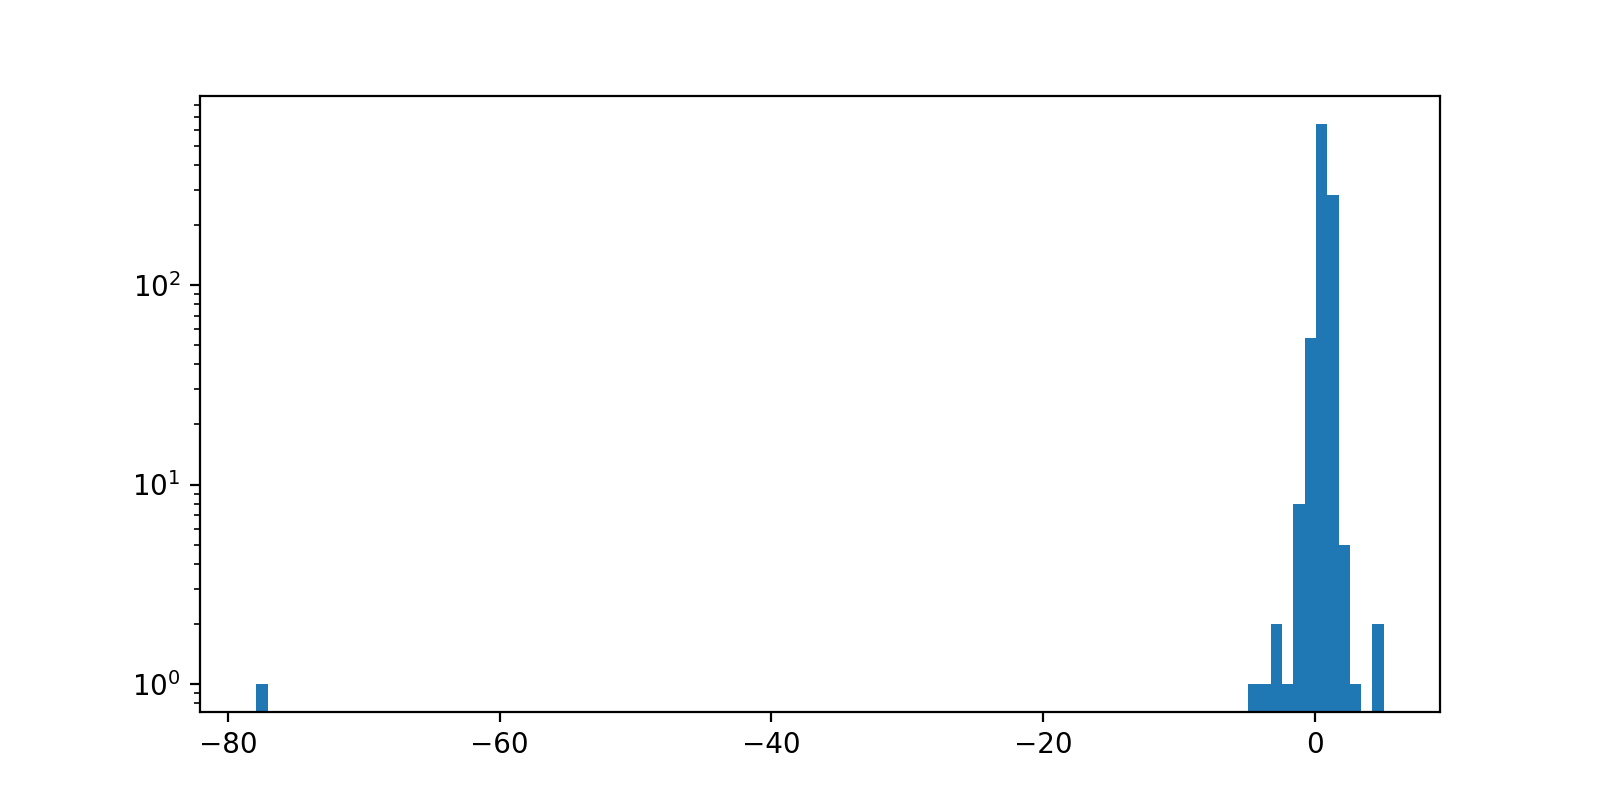

In [115]:
# Histograma coef corr
fig, ax = plt.subplots(figsize=(8,4))
h = ax.hist(thetaCorrelacion[:,4],100,log=True)

## Resultados (3pt)

1. Compare los métodos `CG`, `BFGS`, `Nelder-mead` y `Powell` en términos del vector de parámetros obtenido, la log verosimilitud alcanzada, el pseudo coeficiente de correlación alcanzado, el número de iteraciones necesarias para converger y el tiempo total para converger. Seleccione uno de los métodos para contestar los siguientes puntos
1. Muestre las distribuciones empíricas de los parámetros y del pseudo coeficiente de correlación. ¿Cuáles parámetros tienen $\theta$ significativamente distinto de cero? ¿Cuál es el intervalo de confianza al 95% del $R^2$? En base a esto ¿Qué puede decir sobre su modelo?
1. Prediga la cantidad de billonarios de cada país usando su modelo. Gráfique el error entre la cantidad de billonarios predicha y la cantidad de billonarios real. El gráfico debe mostrar los paises ordenados de mayor a menor **error absoluto**.  Analice ¿Cuáles son los 5 países con mayor error en la predicción? ¿Cuáles países tienen un exceso de billonarios? ¿Cúales paises tienen menos billonarios de lo esperado? ¿Qué puede decir sobre Rusia?



## Conclusiones (0.5pt)

Resuma sus principales hallazgos y comenté sobre las desafios encontrados al desarrollar esta tarea 

In [ ]:
poisson_reg = sm.Poisson(y,xx).fit(cov_type='HC0')
print(poisson_reg.summary())